In [125]:
#Qiskit odds and ends
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP, L_BFGS_B
from qiskit.opflow import Z2Symmetries, X, Y, Z, I, PauliSumOp, Gradient
from qiskit import IBMQ, BasicAer, Aer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.utils.mitigation import CompleteMeasFitter #Measurement error mitigatioin
from qiskit.tools.visualization import circuit_drawer
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeManila, FakeNairobi

#Noise
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error, coherent_unitary_error

#Python odds and ends
import matplotlib
import matplotlib.pyplot as plt
import matplotlib
import pylab
import numpy as np
import os
import pyscf
from IPython.display import display, clear_output

from datetime import datetime
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

IBMQ.load_account()
provider = IBMQ.get_provider(group='deployed')
#set Backends
#simulators
backend_stv = Aer.get_backend('aer_simulator_statevector')
#Noisy simulator
backend_aer = Aer.get_backend('aer_simulator')
#Real Devices
backend_manil = provider.get_backend('ibmq_manila')
backend_qsm_ibm=provider.get_backend('ibmq_qasm_simulator')

sh=1024 #shots

ibmqfactory.load_account:WARNING:2022-09-01 16:08:49,898: Credentials are already in use. The existing account in the session will be replaced.


In [12]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
def make_debugger(depth,num_qubits):
    qr=QuantumRegister(num_qubits)
    cr=ClassicalRegister(num_qubits)
    qc=QuantumCircuit(qr,cr)
    for i in range(depth):
        qc.x(0)
    qc.measure(0,0)
    return qc


In [13]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
num_qubits=1
depth=3
qc=make_debugger(depth,num_qubits)
qc.draw()

┌───┐┌───┐┌───┐┌─┐
  q4: ┤ X ├┤ X ├┤ X ├┤M├
      └───┘└───┘└───┘└╥┘
c3: 1/════════════════╩═
                      0

In [118]:
qcs=[]
max_d=3000
for i in range(max_d):
    depth=i
    qc=make_debugger(depth,num_qubits)
    qcs.append(qc)


In [93]:
qcs[1].draw()

┌───┐┌─┐
 q11705: ┤ X ├┤M├
         └───┘└╥┘
c1138: 1/══════╩═
               0

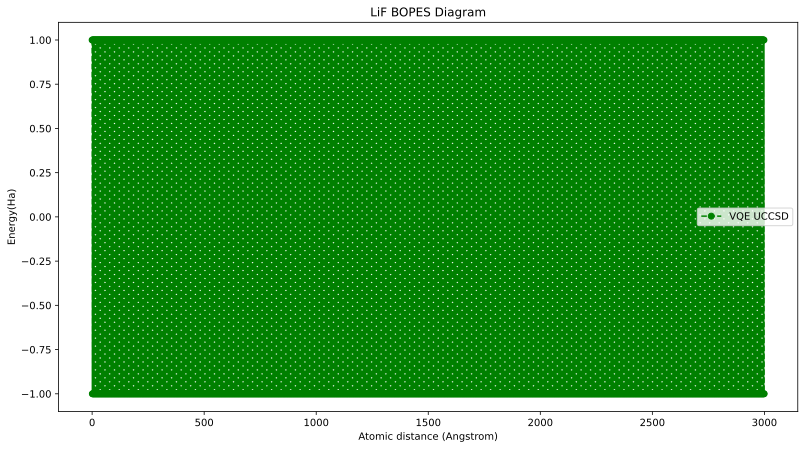

In [119]:
from qiskit.tools.visualization import plot_histogram
exp_vals=[]
depths=[]
for i,circs in enumerate(qcs):
    result=backend_aer.run(qcs[i]).result()
    counts=result.get_counts(qcs[i])
    if counts.get('0',0)==0:
        counts['0']=0
    if counts.get('1',0)==0:
        counts['1']=0
    exp_vals.append(counts['0']/(counts['0']+counts['1'])-counts['1']/(counts['0']+counts['1']))
    depths.append(i)
fig, ax=plt.subplots(1,1,figsize=(11,6))
fig.tight_layout()


ax.plot(depths, exp_vals, '--go',label="VQE UCCSD")
ax.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='LiF BOPES Diagram')
#ax[0].set_xlim([0.7,4])
#ax[0].set_ylim([-148,-147])
ax.legend()

               
               

In [115]:
device_backend=provider.get_backend('ibmq_manila')
device = QasmSimulator.from_backend(device_backend)
noise_model_man = None
coupling_map = device.configuration().coupling_map
noise_model_man = NoiseModel.from_backend(device)
basis_gates = noise_model_man.basis_gates


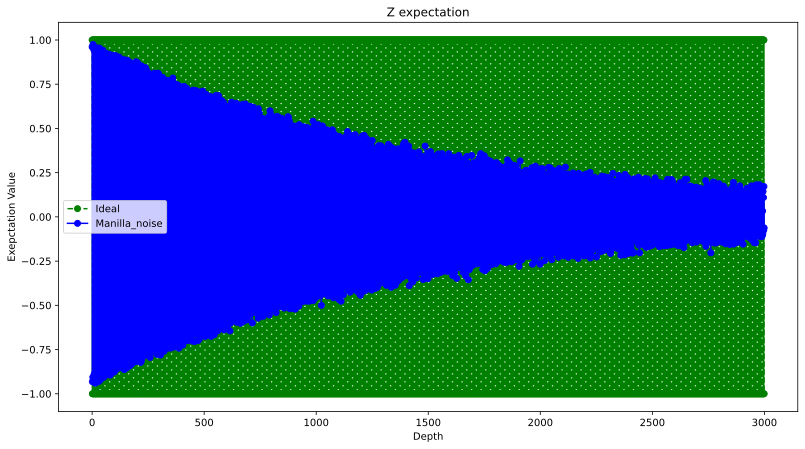

In [120]:
from qiskit.providers.aer import AerSimulator
seed = 62
algorithm_globals.random_seed = seed
#qi=backend_stv

backend_man=AerSimulator(noise_model=noise_model_man)

from qiskit.tools.visualization import plot_histogram
exp_vals_man=[]
depths=[]
for i,circs in enumerate(qcs):
    result=backend_man.run(qcs[i]).result()
    counts=result.get_counts(qcs[i])
    if counts.get('0',0)==0:
        counts['0']=0
    if counts.get('1',0)==0:
        counts['1']=0
    exp_vals_man.append(counts['0']/(counts['0']+counts['1'])-counts['1']/(counts['0']+counts['1']))
    depths.append(i)
fig, ax=plt.subplots(1,1,figsize=(11,6))
fig.tight_layout()

ax.plot(depths, exp_vals, '--go',label='Ideal')
ax.plot(depths, exp_vals_man, '-bo',label='Manilla_noise')
ax.set(xlabel='Depth',ylabel='Exepctation Value',title='Z expectation')
#ax[0].set_xlim([0.7,4])
#ax[0].set_ylim([-148,-147])
ax.legend()

In [122]:

basis=['id','x','sx']
lengths_avg=[]
lengths=[]
T1s=[]
T2s=[]
time_measure=[]
us=1e6
ns=1e9
for k in range(num_qubits):
    T1s.append(backend_manil.properties().t1(k)*ns)
    T2s.append(backend_manil.properties().t2(k)*ns)
    time_measure.append(backend_manil.properties().readout_length(k)*ns)
for i,bas in enumerate (basis):
    for k in range(num_qubits):
        lengths_avg.append(backend_manil.properties().gate_length(bas,k))
    lengths.append(np.mean(lengths_avg)*ns)



In [123]:

# T1 and T2 values for qubits
#T1s = np.random.normal(165.6e3, 76.54e3, num_qubits) # Sampled from normal distribution mean 50 microsec
#T2s = np.random.normal(60.06e3, 27.8e3, num_qubits)  # Sampled from normal distribution mean 70 microsec

# Truncate random T2s <= T1s
#T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(num_qubits)])

# Instruction times (in nanoseconds)
time_x = lengths[1]   
time_sx = lengths[2] 
time_id = lengths[0] 
time_cx = 368
time_reset =np.mean(time_measure)
time_measure = np.mean(time_measure)

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_x  = [thermal_relaxation_error(t1, t2, time_x)
              for t1, t2 in zip(T1s, T2s)]
errors_sx  = [thermal_relaxation_error(t1, t2, time_sx)
              for t1, t2 in zip(T1s, T2s)]
errors_id  = [thermal_relaxation_error(t1, t2, time_id)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(num_qubits):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_x[j], "x", [j])
    noise_thermal.add_quantum_error(errors_sx[j], "sx", [j])
    noise_thermal.add_quantum_error(errors_id[j], "id", [j])
    for k in range(num_qubits):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

print(noise_thermal)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['measure', 'sx', 'x', 'cx', 'reset', 'id']
  Qubits with noise: [0]
  Specific qubit errors: [('reset', (0,)), ('measure', (0,)), ('x', (0,)), ('sx', (0,)), ('id', (0,)), ('cx', (0, 0))]


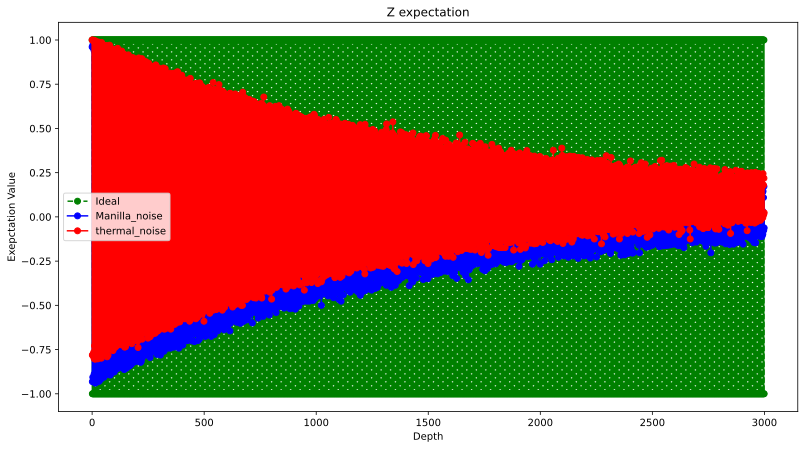

In [158]:
seed = 62
algorithm_globals.random_seed = seed
#qi=backend_stv
backend_therm=AerSimulator(noise_model=noise_thermal)

from qiskit.tools.visualization import plot_histogram
exp_vals_therm=[]
depths=[]
for i,circs in enumerate(qcs):
    result=backend_therm.run(qcs[i]).result()
    counts=result.get_counts(qcs[i])
    if counts.get('0',0)==0:
        counts['0']=0
    if counts.get('1',0)==0:
        counts['1']=0
    exp_vals_therm.append(counts['0']/(counts['0']+counts['1'])-counts['1']/(counts['0']+counts['1']))
    depths.append(i)
fig, ax=plt.subplots(1,1,figsize=(11,6))
fig.tight_layout()

ax.plot(depths, exp_vals, '--go',label='Ideal')
ax.plot(depths, exp_vals_man, '-bo',label='Manilla_noise')
ax.plot(depths, exp_vals_therm, '-ro',label='thermal_noise')
ax.set(xlabel='Depth',ylabel='Exepctation Value',title='Z expectation')
#ax[0].set_xlim([0.7,4])
#ax[0].set_ylim([-148,-147])
ax.legend()

In [156]:
from qiskit.circuit.library import UGate
err=UGate(np.pi,np.pi*j,np.pi)
error_gate1=coherent_unitary_error(err)

coh_noise = NoiseModel()
coh_noise.add_all_qubit_quantum_error(error_gate1, ["x"])


In [168]:
epsilon=0.1
err_x=QuantumCircuit(1,1)
err_x.x(0)
err_x.ry(epsilon,0)
#err_x.x(0)
#err_x.ry(-epsilon,0)

u_err_x=Operator(err_x)

error_gate1=coherent_unitary_error(u_err_x)

coh_noise = NoiseModel()
coh_noise.add_all_qubit_quantum_error(error_gate1, ["x"])

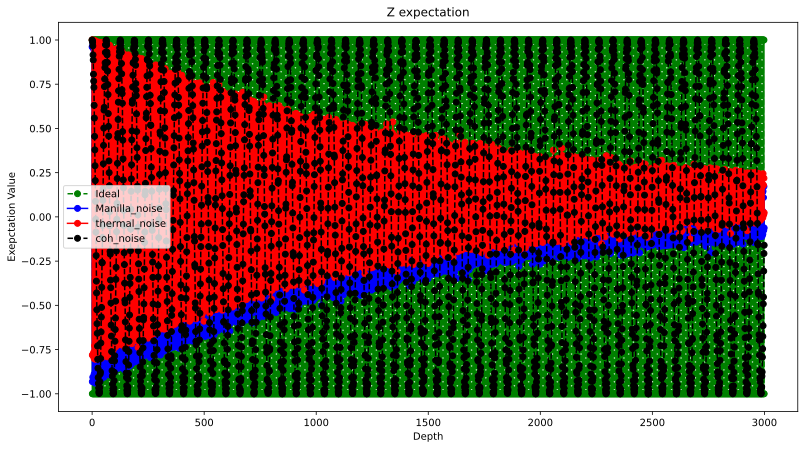

In [169]:
seed = 62
algorithm_globals.random_seed = seed
#qi=backend_stv
backend_coh=AerSimulator(noise_model=coh_noise)

from qiskit.tools.visualization import plot_histogram
exp_vals_coh=[]
depths=[]
for i,circs in enumerate(qcs):
    result=backend_coh.run(qcs[i]).result()
    counts=result.get_counts(qcs[i])
    if counts.get('0',0)==0:
        counts['0']=0
    if counts.get('1',0)==0:
        counts['1']=0
    exp_vals_coh.append(counts['0']/(counts['0']+counts['1'])-counts['1']/(counts['0']+counts['1']))
    depths.append(i)
fig, ax=plt.subplots(1,1,figsize=(11,6))
fig.tight_layout()

ax.plot(depths, exp_vals, '--go',label='Ideal')
ax.plot(depths, exp_vals_man, '-bo',label='Manilla_noise')
ax.plot(depths, exp_vals_therm, '-ro',label='thermal_noise')
ax.plot(depths, exp_vals_coh, '--ko',label='coh_noise')
ax.set(xlabel='Depth',ylabel='Exepctation Value',title='Z expectation')
#ax[0].set_xlim([0.7,4])
#ax[0].set_ylim([-148,-147])
ax.legend()

In [151]:
from qiskit.circuit.library import UGate
err=UGate(np.pi,np.pi*j,np.pi)

In [152]:
err.to_matrix()

array([[ 6.123234e-17+0.00000000e+00j,  1.000000e+00-1.22464680e-16j],
       [ 1.000000e+00+0.00000000e+00j, -6.123234e-17+7.49879891e-33j]])